In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [82]:
df_prueba = pd.DataFrame({
"es_pepito":['s','n','n','s','n','s','n','s','n','s','s','n','s','s','n','s','s','n','n','n','n','s','s','s'],
"es_pepito2":['s','s','s','s','n','s','n','s',None,'s','s','n','s','s',None,'s','s','n','n','n',None,'s','s','s'],
"sexo":['h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h'],
"sexo_2":['h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h','h','m','h'],
"Datos_B":[np.random.randint(0,5) for _ in range(24)],
"Datos_C":[np.random.randint(0,1) for _ in range(24)],
"Datos_D": [np.random.randint(0,1000) for _ in range(24)],
"Datos_E": [np.random.randint(0,1000) for _ in range(24)],
"Datos_F": [np.random.randint(0,1000) for _ in range(24)],
"Datos_G": [np.random.randint(0,1000) for _ in range(24)],
"Datos_cate_A": ['Grupo '+str(np.random.randint(0,6)) for _ in range(24)],
"Datos_cate_B": ['Grupo '+str(np.random.randint(0,4)) for _ in range(24)],
"Datos_cate_C": ['Grupo '+str(np.random.randint(0,5)) for _ in range(24)],

})

In [83]:

class DF_exploracion(pd.DataFrame):

    def __init__(self, *args, **kw):
        super(DF_exploracion, self).__init__(*args, **kw)
        self.cuanti=pd.DataFrame
        self.cuali=pd.DataFrame
        self.dico=pd.DataFrame
        self.cate=pd.DataFrame
        self.dummy=pd.DataFrame
        self.df=pd.DataFrame
        self.df_limpio=pd.DataFrame
        self.normal_cuatis=[]
        self.normal_grupos_dico=[]
        self.normal_grupos_cate=[]


    def variables(self):

        dico=[]
        cuantis=[]
        categori=[]
        eliminar=[]

        # print("|----------------------------------------------------------------------------------------------------")
        for i in self.columns: 
            if len(self[i].dropna().unique())==2:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: DICOTOMICA"
                dico.append(i)

            elif len(self[i].dropna().unique())>10:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CUANTITATIVA"
                cuantis.append(i)

            elif  len(self[i].dropna().unique())<2:
                tipo_de_var=f"SOLO {len(self[i].dropna().unique())} TIPOS, NO VALE LA COLUMNA"
                eliminar.append(i)
            else:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CATEGORICA/CUANTI"
                categori.append(i)

            print (f"|  {i} \n|   - Tipo de dato: {self[i].dtype} \n|   - Valores repetidos: {tipo_de_var} \n|   - Nulos: {self[i].isnull().sum()/len(self[i])} \n| ")

        print (f"|----------------------------------------------------------------------------------------------------\n|  TODAS: {self.columns} \n|  DICOTOMICAS: {dico} \n|  CATEGORICAS: {categori} \n|  CUANTITATIVAS: {cuantis} \n|  ELIMINAR: {eliminar}")
        print("|----------------------------------------------------------------------------------------------------")

        self.DF_cuantis(cuantis)
        self.DF_cualis(categori+dico)
        self.DF_dicotomica(dico)
        self.DF_categorica(categori)
        self.df=self
        
    def todas_col(self):
        return self.df
    
    def DF_cuantis(self,lista):
        self.cuanti=self[lista]
        
    def DF_cualis(self,lista):
        self.cuali=self[lista]
        
    def DF_dicotomica(self, lista):
        self.dico=self[lista]
        
    def DF_categorica(self, lista):
        self.cate=self[lista]   



    def limpiar_aux(self):
        
        try:
            df_nuevo=pd.DataFrame
            aux1=list(self.dico.columns)
            aux=[]
            df_nuevo=pd.get_dummies(self.df, columns=aux1)
            
            for columna in df_nuevo.columns:
                for variables in list(self.dico.columns):
                    if variables in columna:
                        aux.append(columna)
                    
            self.dummy=df_nuevo[aux]
            self[aux]=df_nuevo[aux]

            # self.df=self.drop(columns=var, axis='columns')
            # self.df= self[self.columns.difference(self.dico.columns)]
            
            print("********************** self.dummy ************\n")
            print(self.dummy)
            print("\n********************** self.df o todas_las_col() ************\n")
            print(self.df)

        except:
            print("---------------------- ERROR -----------------")



    def limpiar_dummys(self):

        b=False
        lista=list(self.dico.columns)
        for ind, i in enumerate(lista):
                if (ind+1<len(lista)):
                    if( (i in lista [ind+1]) ):
                        b=True
                        break
        if b:
            nombres_nuevos=[]
            if len(lista)>2:
                for ind, i in enumerate(lista):
                    if (ind+1<len(lista)):
                        if( (i in lista [ind+1]) ):
                            nombres_nuevos.append(i.upper())
                        else:
                            nombres_nuevos.append(i)
                    else:
                        nombres_nuevos.append(i)
                        
            aux_df=self.df

            for i,j in zip(lista,nombres_nuevos):
                aux_df.rename(columns={i:j},inplace=True)
                
            self.df=aux_df
            self.dico.columns=nombres_nuevos
            
            self.limpiar_aux()
        else: 
            self.limpiar_aux()



    def estadistica_descriptiva_cuantis(self):

        print("----------------------------------------------------------------------------------------------------\nDESCRIPCIÓN")
        print (self.cuanti.describe())
        print("\n")
        print("----------------------------------------------------------------------------------------------------\nCUARTILES")
        print (self.cuanti.quantile([0.05,0.25,0.5,0.75,0.95]))
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")


        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        # df_auxiliar = self.groupby('sexo').apply(lambda x: pd.Series(shapiro(x), index=['W','P'])).reset_index()
        # print(df_auxiliar)
                
        for a in list(aux1.values):
            
            for b in list(aux.values):
                
                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                agrupado=self.groupby(a)[b]
                titulo=f"Agrupado por {a} y por {b}"
                print(titulo)
                print(agrupado.describe().reset_index())
                # df.groupby(['cat1', 'cat2'])['purchases','sales'].apply(stats.shapiro)
                print("////////////////////////// TEST DE SHAPIRO ////////////////////////////")
                aux_shapiro=(agrupado.apply(stats.shapiro))
                print(aux_shapiro)
        
                
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")


    def estadistica_descriptiva_cualis(self):

        print("\n--------------------- Variables dico ---------------------")
        print("\n")
        for i in self.dico.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")

        print("\n-------------------- Variables categoricas --------------------")
        print("\n")
        for i in self.cate.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")
        print("\n\n")

        # crosstab variables cualis con cate
        aux=list(self.cate.columns)

        a=0
        for i in aux:
            a=a+1
            if a<len(aux)/2:
                b=0
                for j in aux[:-1]:
                    b=b+1
                    if b > a:
                        print(f"*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} *********************\n ")
                        tab = pd.crosstab (index=self[i], columns=self[j])
                        x=(tab/tab.sum())
                        print(tab)
                        print("\n")
                        print(f"/////////////////// EN PROPORCION //////////////////\n")
                        print(x)
                        print("\n\n")


    def anova(self):

        aux_cate=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for i in aux_cate:
            for j in aux_cuati:
                print(f"\n----------- ANOVA Categoria {i} y variable continua {j} ----------\n")
                model = ols(f"{j} ~ {i}", data=self).fit()
                a=sm.stats.anova_lm(model, typ=2)
                print(a)




    def Chi(self):

        aux_dico=list(self.dico.columns)

        if len(aux_dico)>1:
            for ind, i in enumerate(aux_dico):
                for j in range(ind+1,len(aux_dico)):
                    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(self[i],self[aux_dico[j]]), correction=False)
                    print(f"\n-------------- Chi2 entre {i} y {aux_dico[j]} ----------------")
                    print(f"p: {p} \n") 
        else:
            print("******************** No suficientes argumentos ********************")


    def plot_normailidad(self):

        aux=self.cuanti.columns

        for i in aux:

            stats.probplot(self[i], dist="norm", plot=plt)
            plt.title("Probability Plot - " )
            plt.show()


    def plots(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("-------------- Graficas de bigotes cualitativas-------------------")
        # fig = plt.figure(figsize=(12, 8))
        
        (self.cuanti).plot(kind='box', title='Variables cuantitativas',figsize=(12, 8))
        plt.show()
        

        print("-------------- Graficas de bigotes por dicotomicas-------------------")   
        
        for a in aux1:

            # fig = plt.figure(figsize=(12, 8))
            self.boxplot(column=list(aux.values), by=a,figsize=(12, 8))
            plt.tight_layout() 
            plt.show()
        
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- Graficas de bigotes por categoricas-------------------") 

        for a in aux2:
            # fig = plt.figure(figsize=(12, 8))
            ax= self.boxplot(column=list(aux.values), by=a, figsize=(12, 8))
            # ax = sns.swarmplot(column=list(aux.values), by=a,data=self, color='#7d0013')
            plt.tight_layout() 
            plt.show()
        

        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------\n") 

        fig = plt.figure(figsize=(12, 8))
        matrix = self.cuanti.corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)  
        plt.show()

        print("----------------------------------------------------------------------------------------------------\n")

        print("-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------\n") 
        # fig = plt.figure(figsize=(15, 20))
        self.cuanti.plot.bar(figsize=(18, 8))
        plt.show()

        print("-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------\n") 
        for i in list(aux.values):
            fig = plt.figure(figsize=(12, 8))
            print(f"\n.............. GRAFICA DE BARRAS  DE {i} ............\n") 
            ax=self[i].plot.hist(density=True)
            self[i].plot.density(ax=ax)
            plt.show()

        
        a=0
        for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            ax=self.plot.scatter(x=i,y=j,figsize=(4,4))
                            ax.set_xlabel(i)
                            ax.set_ylabel(j)
                            ax.axhline(np.mean(self[i]),color='grey',lw=1)
                            ax.axvline(np.mean(self[j]),color='grey',lw=1)
                            plt.show()
        print("\n----------------------------------------------------------------------------------------------------\n")

    def violines(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("--------------  GRAFICA DE VIOLINES  -------------------\n") 
        sns.set(style="whitegrid")
        for i in aux2:
            for j in aux:
                ax= sns.violinplot(x=self[i], y=self[j], palette="Set2", split=True, inner="quartile",scale="count")
                plt.show()

        print("\n\n/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////\n") 
        
        for i in aux2:
            for j in aux:
                for k in aux1:
                    ax= sns.violinplot(x=self[i], y=self[j], hue=self[k],palette="Set2", split=True, inner="quartile",scale="count")
                    plt.show()


    def cross_var_cualis_con_ciantis(self):

        aux=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for k in aux_cuati:
            a=0
            for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            print(f"\n\n*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} con valores de {k} MEDIA *********************\n ")
                            tab = pd.crosstab (index=self[i], columns=self[j],values=self[k],aggfunc=np.mean)
                            print(tab)
                            print("\n\n")


    def normalidad(self):
        
        DataF=self.df
        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
                
        for b in list(aux.values):
            aux_shapiro=(stats.shapiro(DataF[b]))
            if(aux_shapiro.pvalue<0.05):
                print("////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////")
                print("++++++++++++++++++++++++++++  "+ b +"  ++++++++++++++++++++++++++\n")
                titulo=f"Variable cuantitativa {b} y test Shapiro < 0.05"
                print(titulo)
                print(aux_shapiro)
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")
                self.normal_cuatis.append(b)

        
        for a in list(aux1.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby(a)[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(aux_shapiro)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_dico.append([a,b])
                    except:
                        continue 

        for a in list(aux2.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby([a])[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO CATEGORICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(h)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_cate.append([a,b])
                    except:
                        continue 

# CREACIÓN DE LA CLASE

In [84]:
ejemplo=DF_exploracion(df_prueba)


C:\Users\franc\AppData\Local\Temp\ipykernel_6944\2732381236.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.normal_cuatis=[]
C:\Users\franc\AppData\Local\Temp\ipykernel_6944\2732381236.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.normal_grupos_dico=[]
C:\Users\franc\AppData\Local\Temp\ipykernel_6944\2732381236.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.normal_grupos_cate=[]


# DEFINICIÓN DE LAS VARIABLES

In [85]:
ejemplo.variables()


|  es_pepito 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  es_pepito2 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.125 
| 
|  sexo 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  sexo_2 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_B 
|   - Tipo de dato: int64 
|   - Valores repetidos: 5 tipos, posiblemente: CATEGORICA/CUANTI 
|   - Nulos: 0.0 
| 
|  Datos_C 
|   - Tipo de dato: int64 
|   - Valores repetidos: SOLO 1 TIPOS, NO VALE LA COLUMNA 
|   - Nulos: 0.0 
| 
|  Datos_D 
|   - Tipo de dato: int64 
|   - Valores repetidos: 24 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_E 
|   - Tipo de dato: int64 
|   - Valores repetidos: 24 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_F 
|   - Tip

## Creación de variables dummys a traves de dicotómicas

In [86]:
ejemplo.limpiar_dummys()

********************** self.dummy ************

    ES_PEPITO_n  ES_PEPITO_s  es_pepito2_n  es_pepito2_s  SEXO_h  SEXO_m  \
0             0            1             0             1       1       0   
1             1            0             0             1       0       1   
2             1            0             0             1       1       0   
3             0            1             0             1       1       0   
4             1            0             1             0       0       1   
5             0            1             0             1       1       0   
6             1            0             1             0       1       0   
7             0            1             0             1       0       1   
8             1            0             0             0       1       0   
9             0            1             0             1       1       0   
10            0            1             0             1       0       1   
11            1            0            

## Revisión de todas las columnas

In [87]:
# ejemplo.df
# ejemplo.cuanti
# ejemplo.dummy
# ejemplo.dico
ejemplo.df


,ES_PEPITO,es_pepito2,SEXO,sexo_2,Datos_B,Datos_C,Datos_D,Datos_E,Datos_F,Datos_G,...,Datos_cate_B,Datos_cate_C,ES_PEPITO_n,ES_PEPITO_s,es_pepito2_n,es_pepito2_s,SEXO_h,SEXO_m,sexo_2_h,sexo_2_m
0,s,s,h,h,3,0,742,973,840,784,...,Grupo 1,Grupo 4,0,1,0,1,1,0,1,0
1,n,s,m,m,2,0,989,144,313,343,...,Grupo 2,Grupo 1,1,0,0,1,0,1,0,1
2,n,s,h,h,0,0,430,397,777,561,...,Grupo 2,Grupo 1,1,0,0,1,1,0,1,0
3,s,s,h,h,4,0,605,665,350,976,...,Grupo 1,Grupo 3,0,1,0,1,1,0,1,0
4,n,n,m,m,4,0,588,672,743,13,...,Grupo 1,Grupo 1,1,0,1,0,0,1,0,1
5,s,s,h,h,3,0,686,158,775,110,...,Grupo 2,Grupo 2,0,1,0,1,1,0,1,0
6,n,n,h,h,0,0,928,643,638,513,...,Grupo 2,Grupo 4,1,0,1,0,1,0,1,0
7,s,s,m,m,3,0,936,824,323,255,...,Grupo 0,Grupo 0,0,1,0,1,0,1,0,1
8,n,None,h,h,2,0,2,305,828,630,...,Grupo 1,Grupo 4,1,0,0,0,1,0,1,0
9,s,s,h,h,1,0,428,872,947,169,...,Grupo 0,Grupo 4,0,1,0,1,1,0,1,0


# ESTADISTICA DESCRIPTIVA

In [88]:
ejemplo.estadistica_descriptiva_cuantis()

----------------------------------------------------------------------------------------------------
DESCRIPCIÓN
          Datos_D     Datos_E     Datos_F     Datos_G
count   24.000000   24.000000   24.000000   24.000000
mean   606.375000  554.583333  500.125000  407.708333
std    278.392718  278.007025  272.378623  329.849436
min      2.000000   97.000000   55.000000   10.000000
25%    428.750000  304.250000  289.000000  145.250000
50%    622.500000  580.500000  528.500000  346.000000
75%    807.000000  767.000000  745.750000  668.500000
max    989.000000  981.000000  947.000000  976.000000


----------------------------------------------------------------------------------------------------
CUARTILES
      Datos_D  Datos_E  Datos_F  Datos_G
0.05   105.15   146.10   141.30    13.75
0.25   428.75   304.25   289.00   145.25
0.50   622.50   580.50   528.50   346.00
0.75   807.00   767.00   745.75   668.50
0.95   978.85   970.90   838.20   972.50


----------------------------------------

In [89]:
ejemplo.estadistica_descriptiva_cualis()


--------------------- Variables dico ---------------------


...........Frecuencia variable ES_PEPITO ....................
s    0.541667
n    0.458333
Name: ES_PEPITO, dtype: float64


...........Frecuencia variable es_pepito2 ....................
s    0.714286
n    0.285714
Name: es_pepito2, dtype: float64


...........Frecuencia variable SEXO ....................
h    0.666667
m    0.333333
Name: SEXO, dtype: float64


...........Frecuencia variable sexo_2 ....................
h    0.666667
m    0.333333
Name: sexo_2, dtype: float64



-------------------- Variables categoricas --------------------


...........Frecuencia variable Datos_B ....................
0    0.250000
3    0.208333
1    0.208333
2    0.166667
4    0.166667
Name: Datos_B, dtype: float64


...........Frecuencia variable Datos_cate_A ....................
Grupo 2    0.333333
Grupo 3    0.166667
Grupo 5    0.166667
Grupo 4    0.125000
Grupo 0    0.125000
Grupo 1    0.083333
Name: Datos_cate_A, dtype: float64


.....

In [90]:
ejemplo.cross_var_cualis_con_ciantis()



*************** TABAL DE VARIABLES CATEGORICAS Datos_B y Datos_cate_A con valores de Datos_D MEDIA *********************
 
Datos_cate_A  Grupo 0  Grupo 1  Grupo 2  Grupo 3  Grupo 4  Grupo 5
Datos_B                                                           
0                 NaN      NaN    944.5    322.0    429.5    225.0
1                 NaN      NaN    809.0    562.0      NaN    428.0
2               188.5    989.0      NaN    813.0      NaN      NaN
3               665.0    742.0    686.0      NaN    576.0    936.0
4                 NaN      NaN    432.0    605.0      NaN    588.0





*************** TABAL DE VARIABLES CATEGORICAS Datos_B y Datos_cate_B con valores de Datos_D MEDIA *********************
 
Datos_cate_B     Grupo 0  Grupo 1  Grupo 2  Grupo 3
Datos_B                                            
0             429.000000    322.0    773.0    225.0
1             738.333333    562.0      NaN    640.0
2             594.000000      2.0    989.0      NaN
3             936.

# PLOTS

-------------- Graficas de bigotes cualitativas-------------------


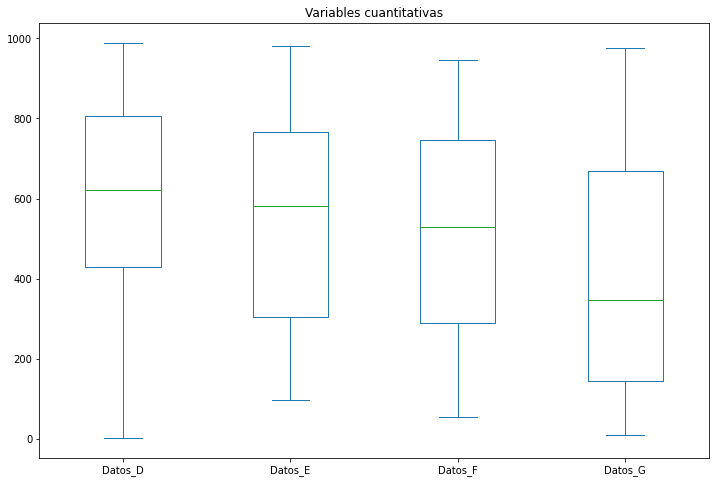

-------------- Graficas de bigotes por dicotomicas-------------------


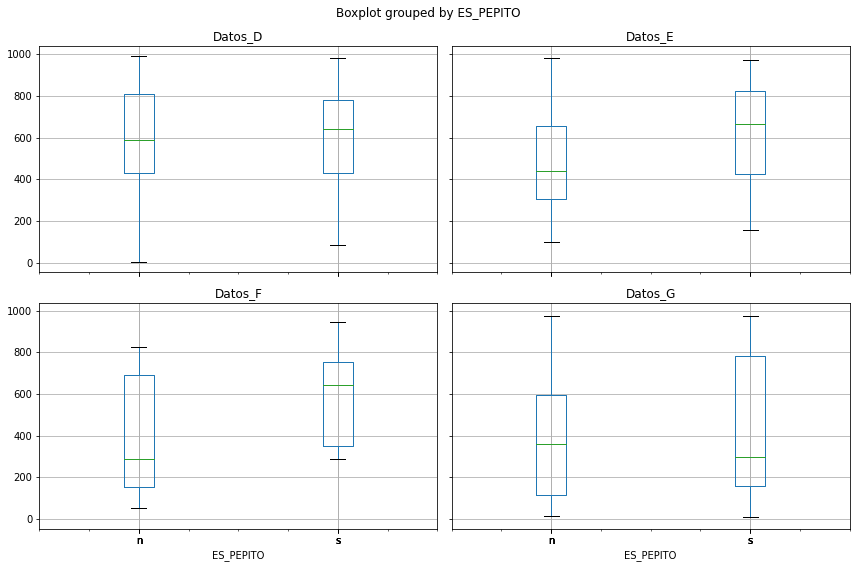

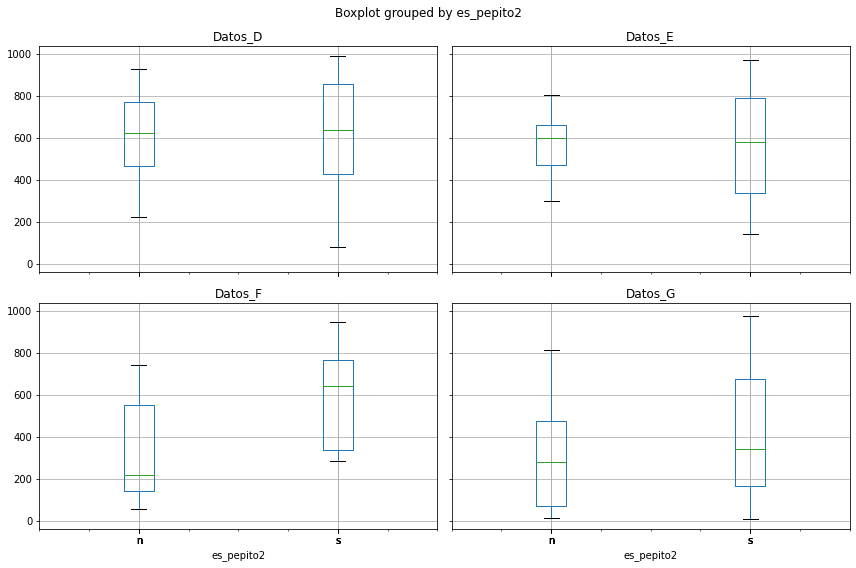

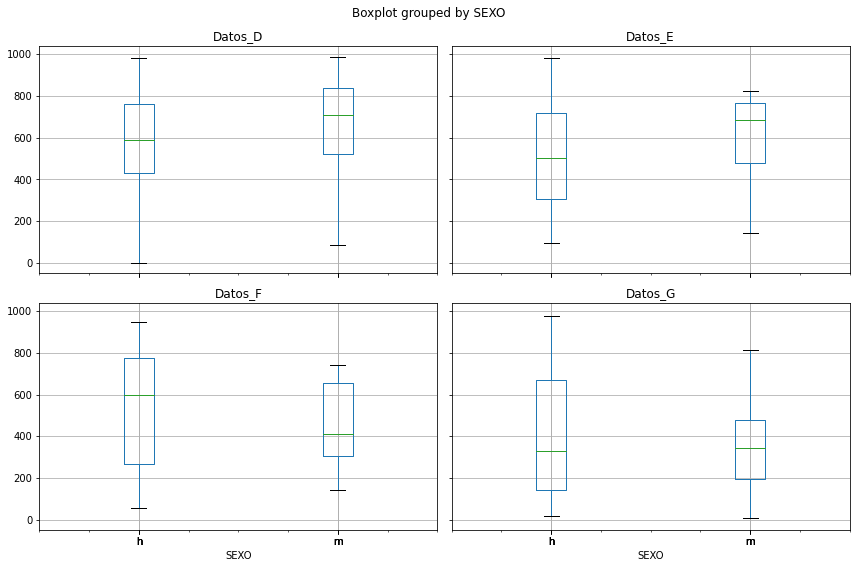

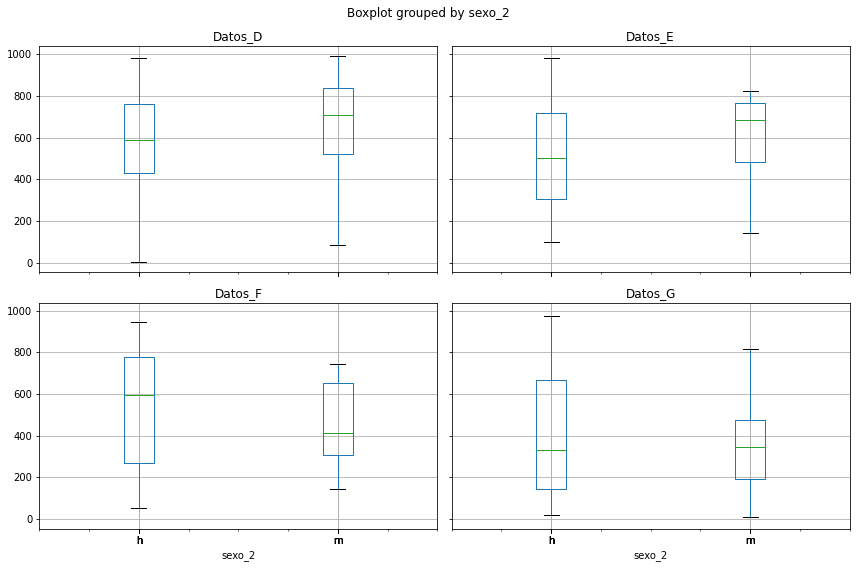



----------------------------------------------------------------------------------------------------

-------------- Graficas de bigotes por categoricas-------------------


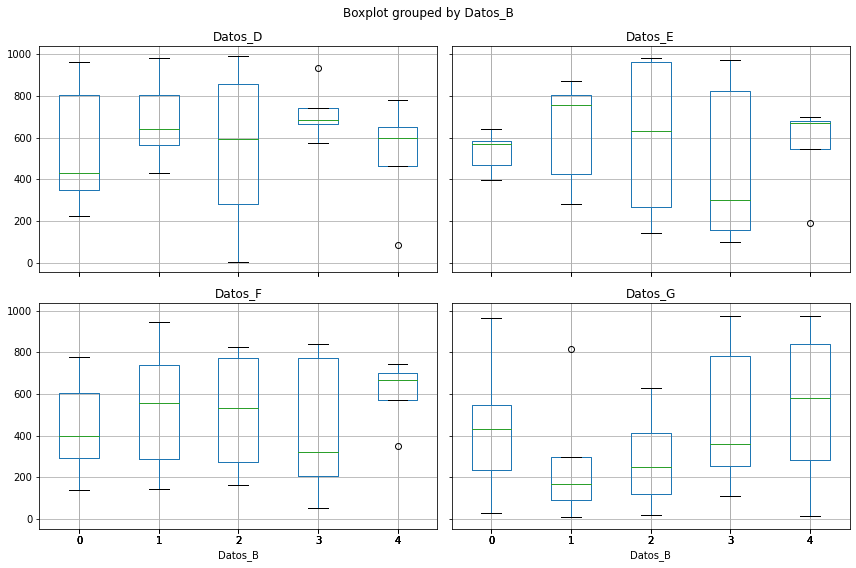

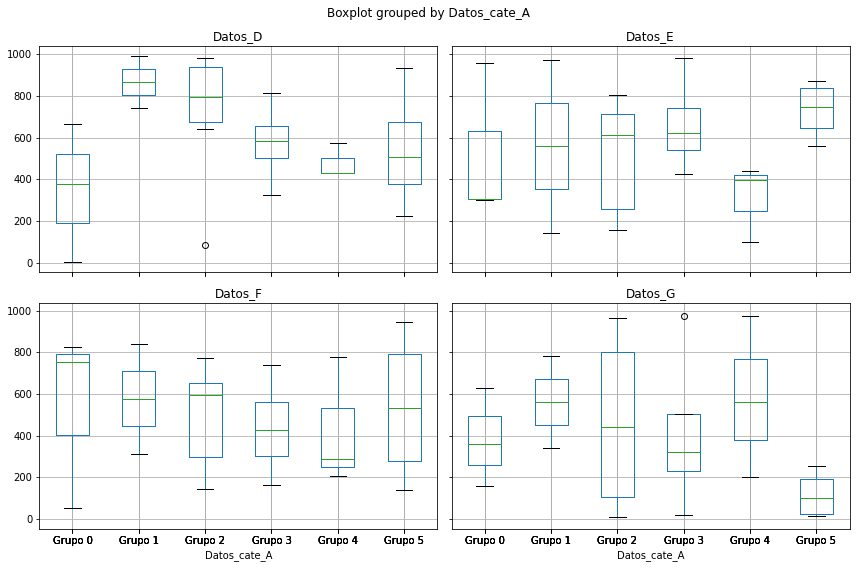

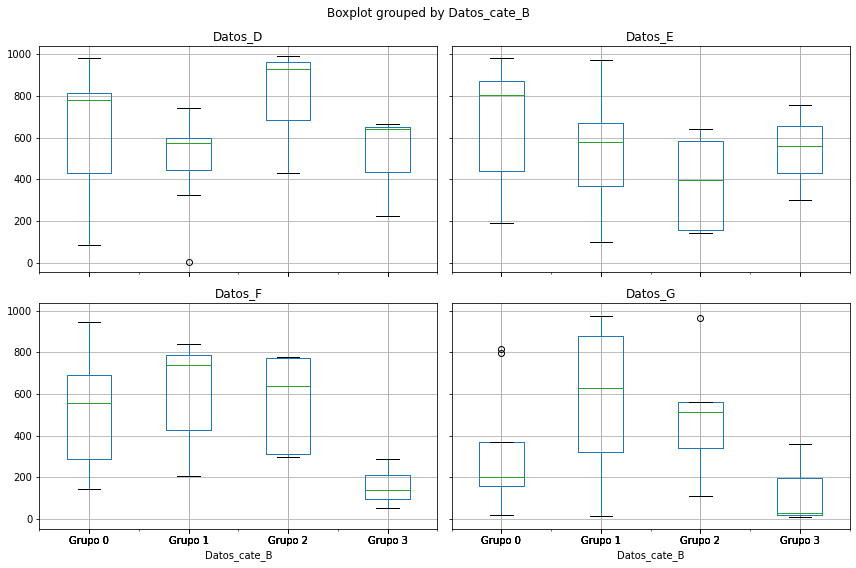

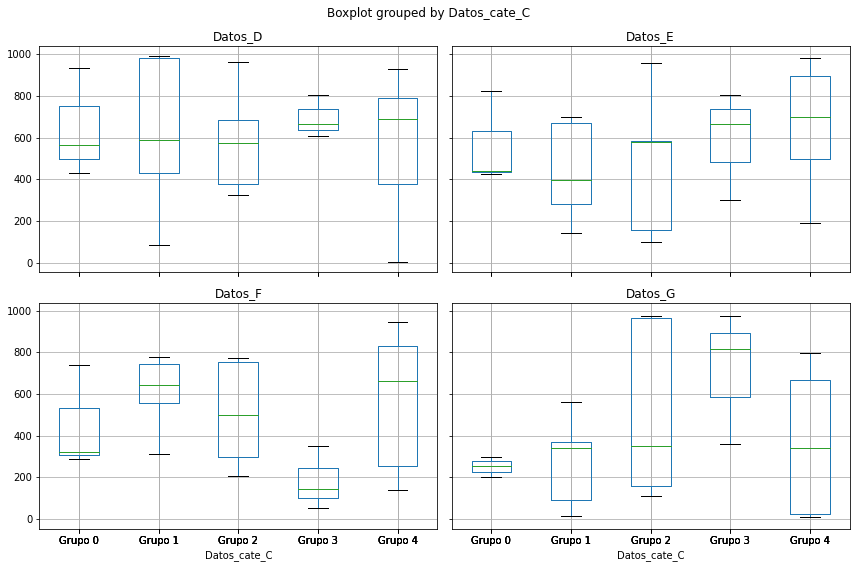



----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------



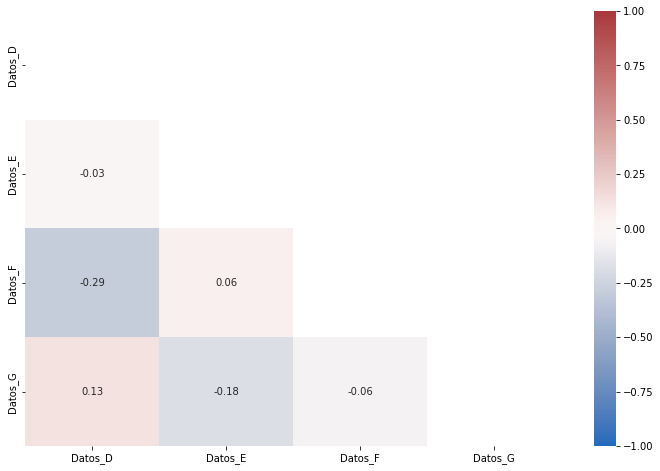

----------------------------------------------------------------------------------------------------

-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------



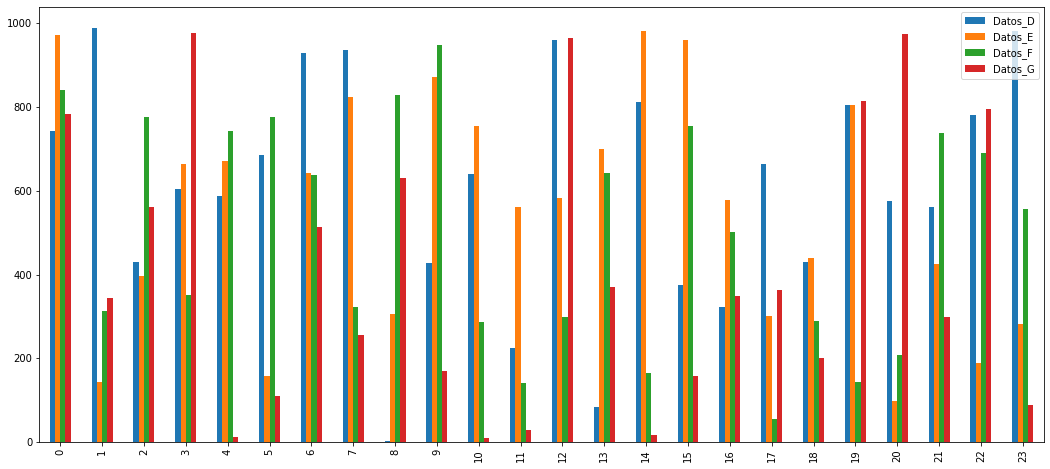

-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------


.............. GRAFICA DE BARRAS  DE Datos_D ............



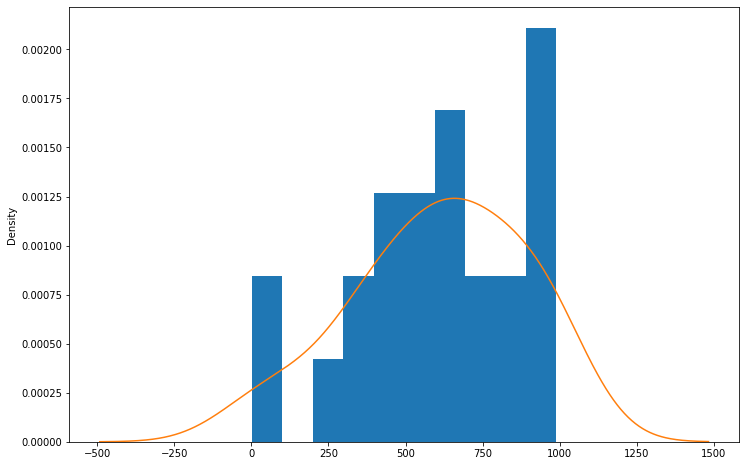


.............. GRAFICA DE BARRAS  DE Datos_E ............



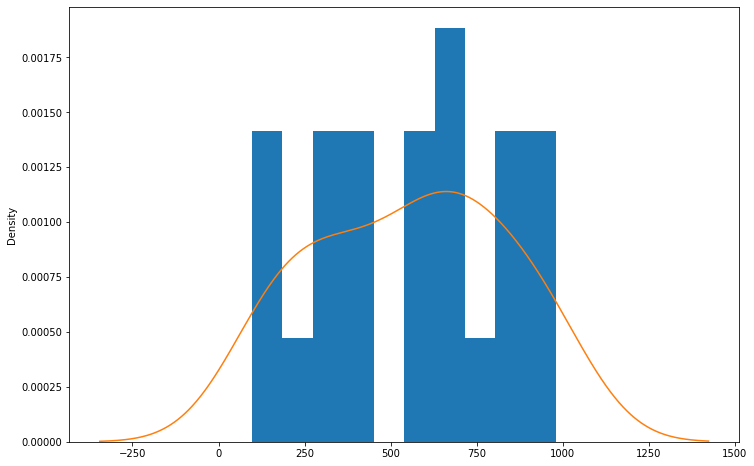


.............. GRAFICA DE BARRAS  DE Datos_F ............



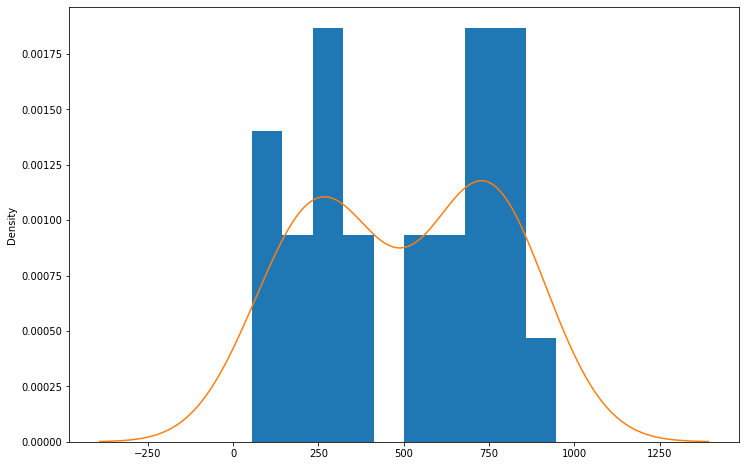


.............. GRAFICA DE BARRAS  DE Datos_G ............



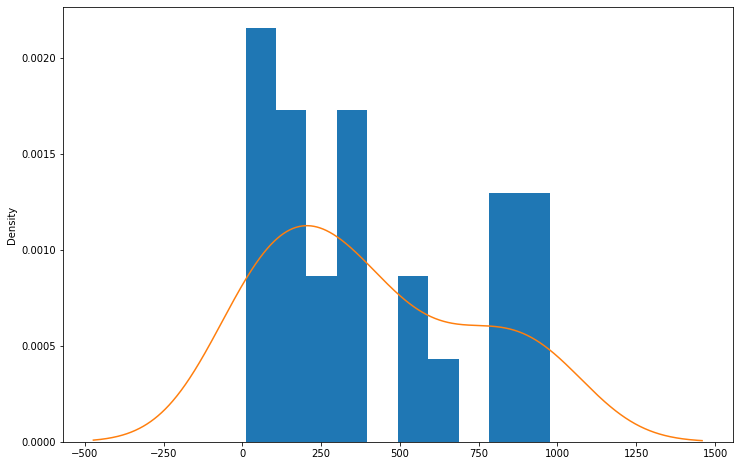

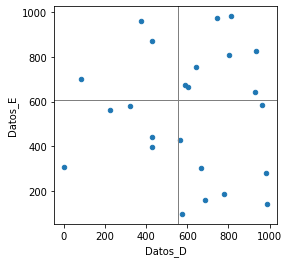

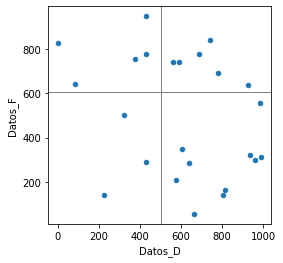


----------------------------------------------------------------------------------------------------



In [91]:
ejemplo.plots()

--------------  GRAFICA DE VIOLINES  -------------------



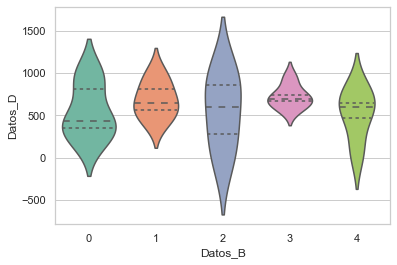

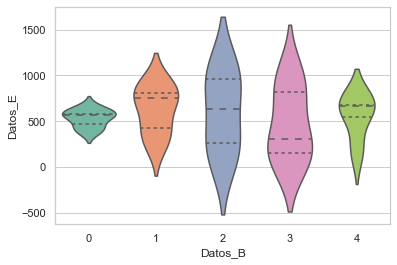

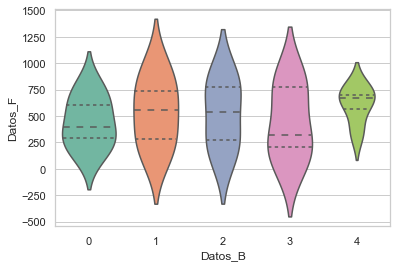

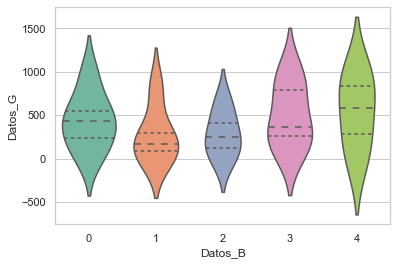

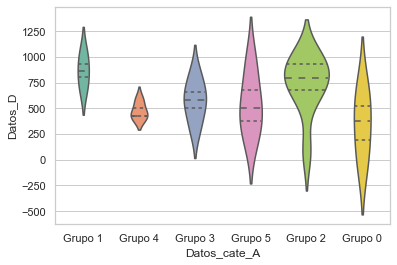

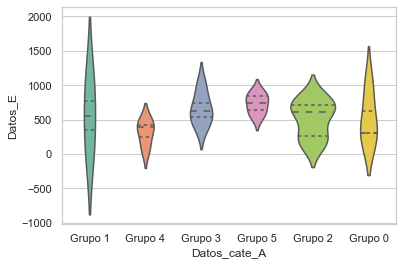

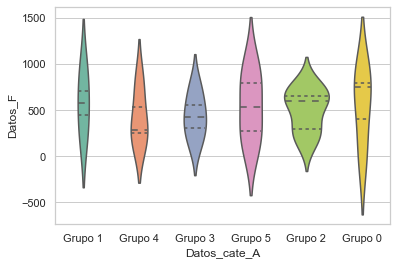

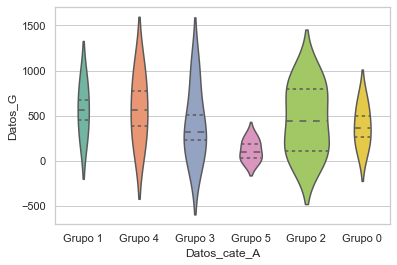

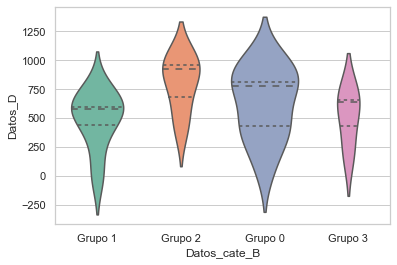

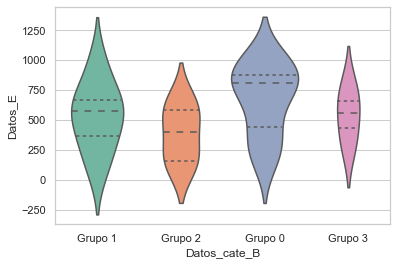

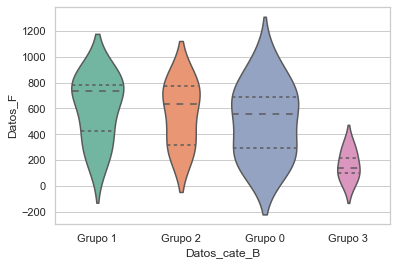

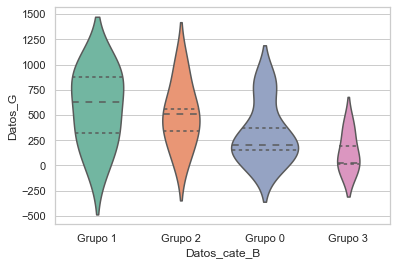

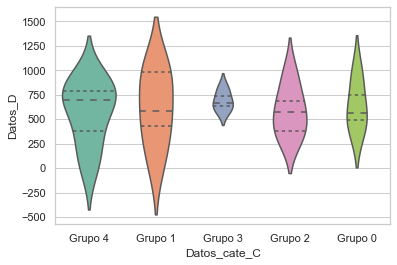

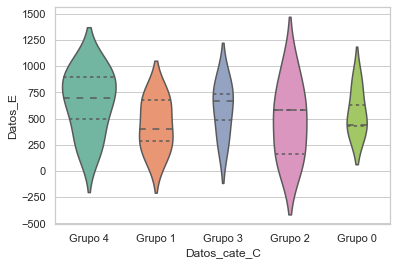

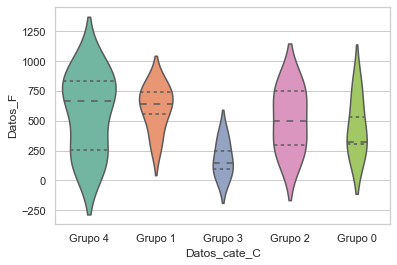

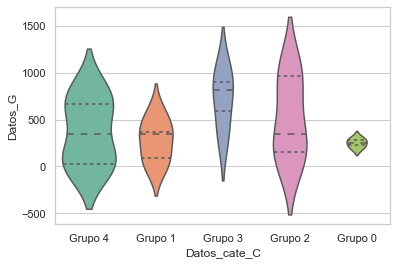



/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////



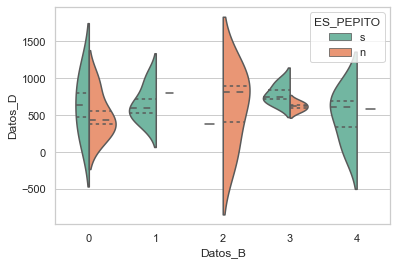

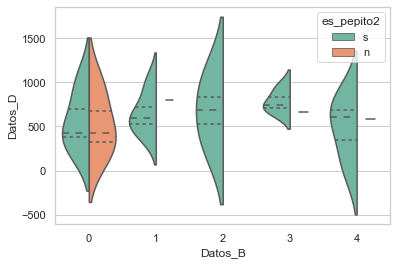

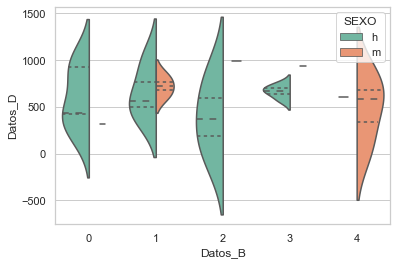

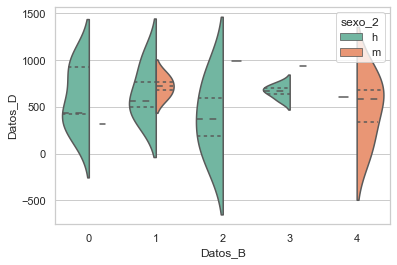

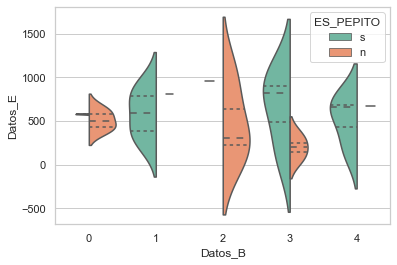

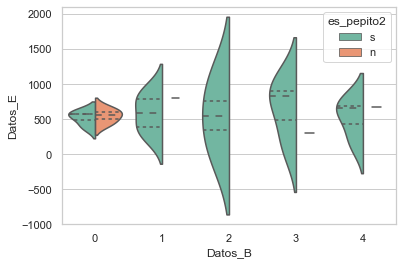

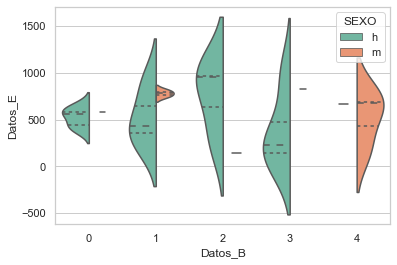

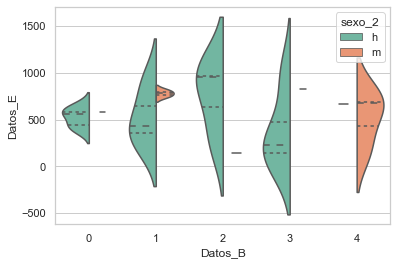

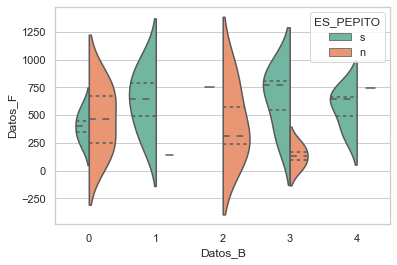

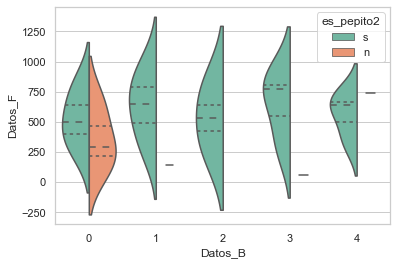

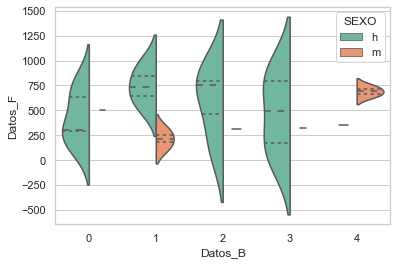

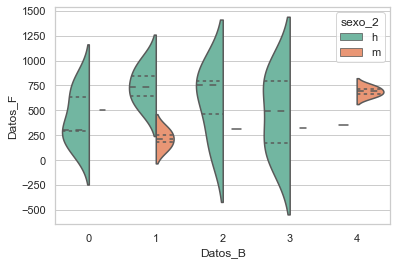

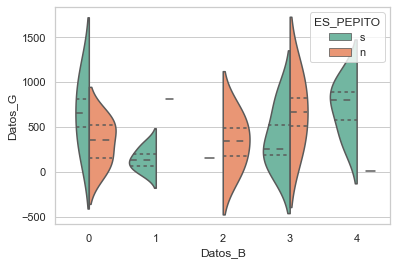

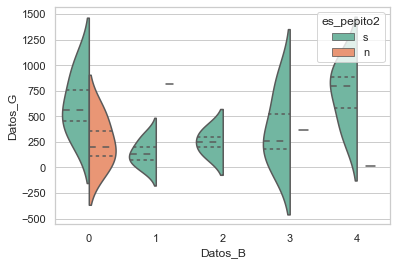

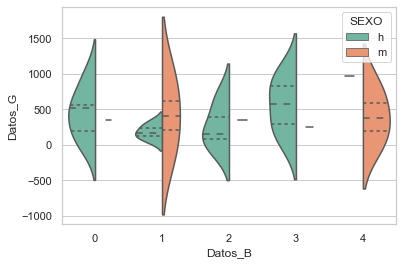

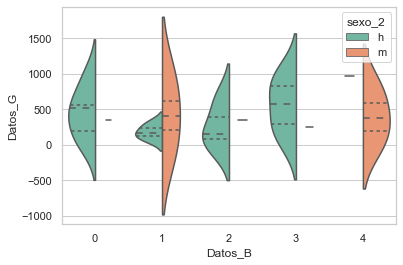

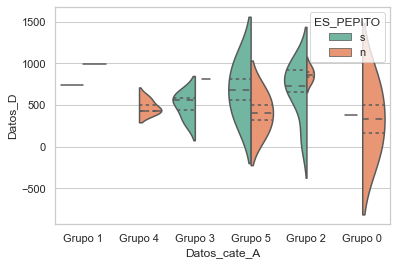

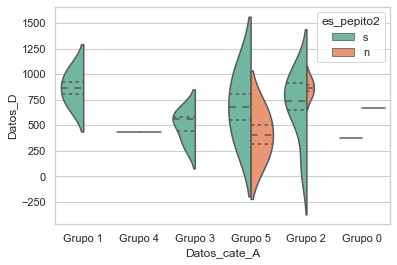

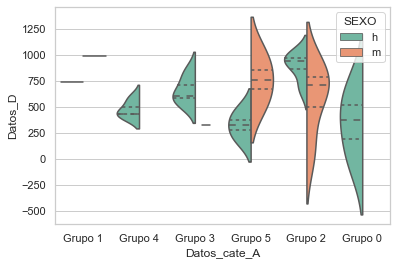

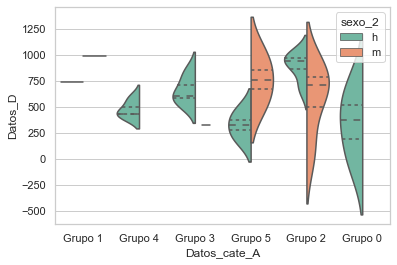

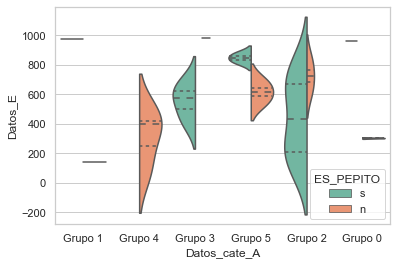

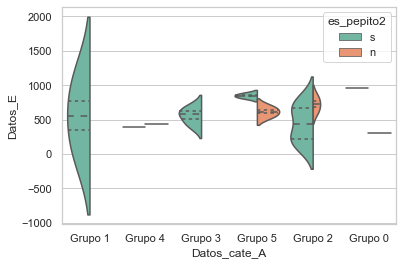

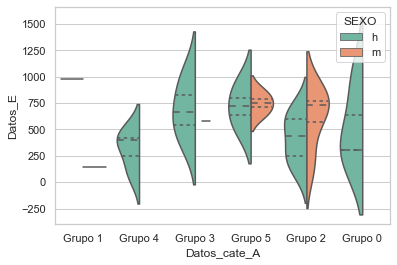

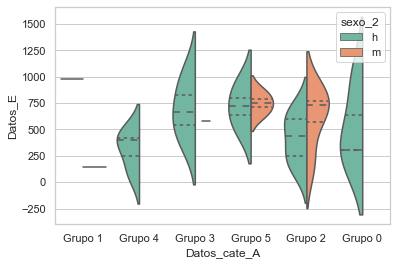

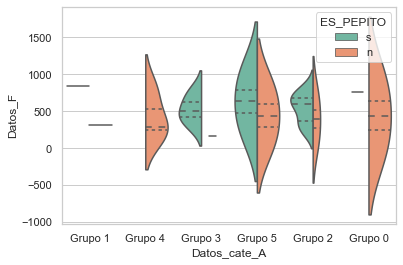

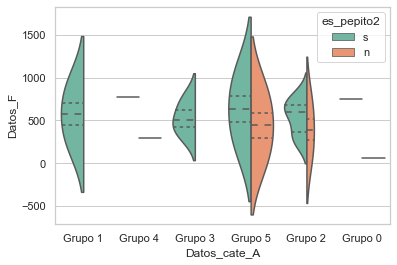

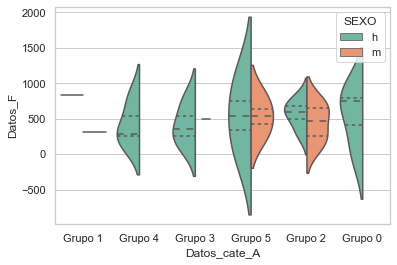

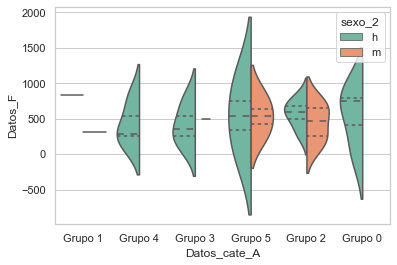

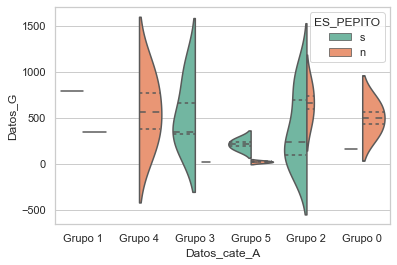

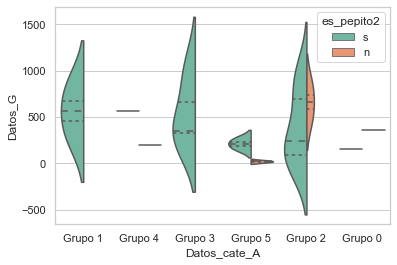

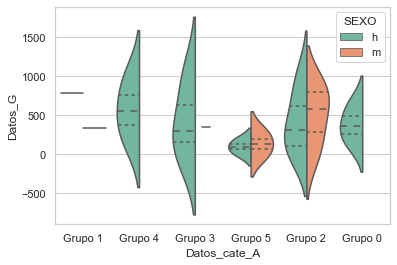

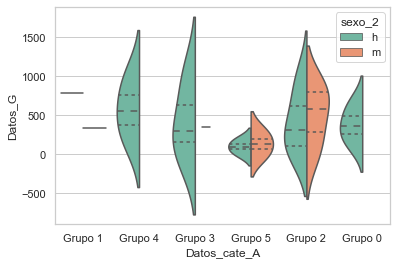

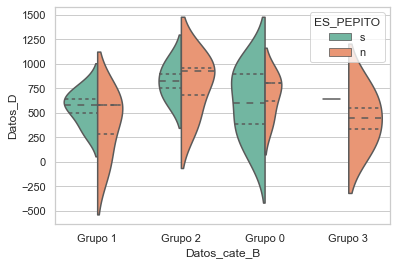

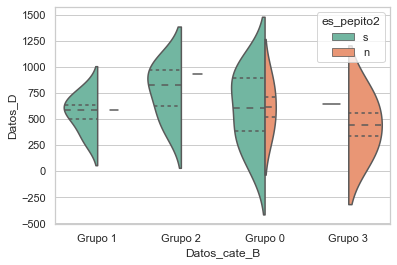

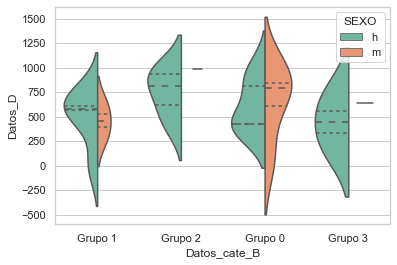

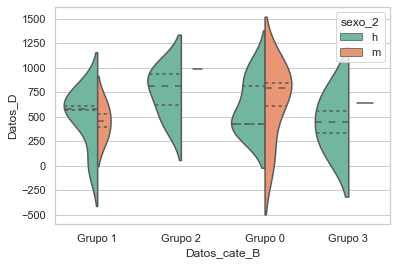

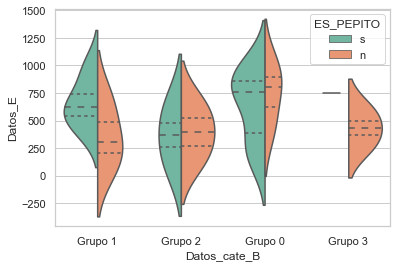

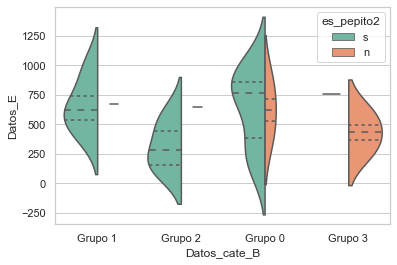

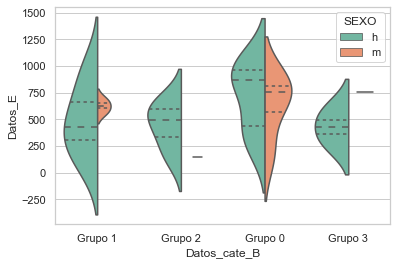

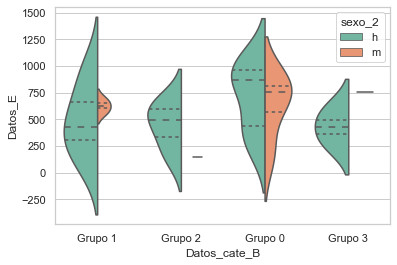

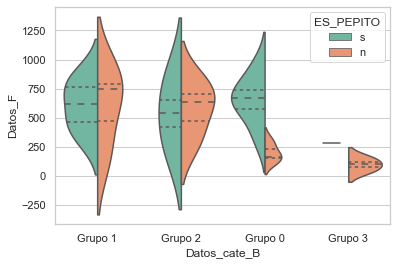

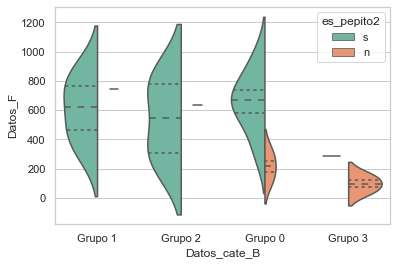

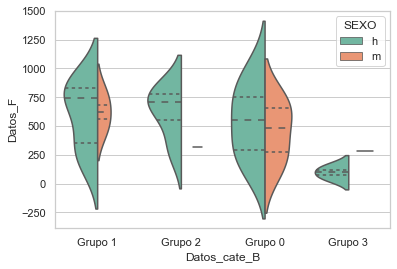

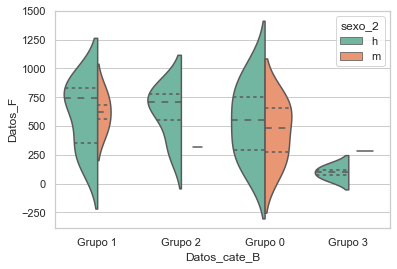

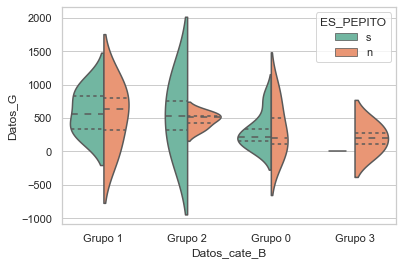

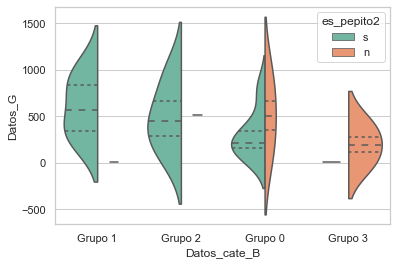

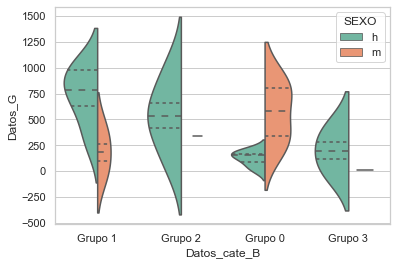

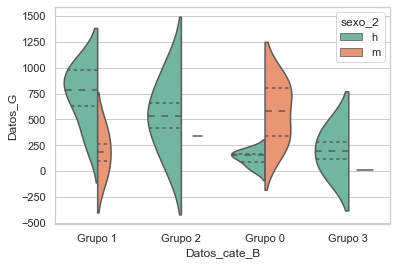

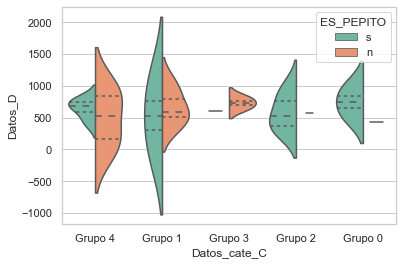

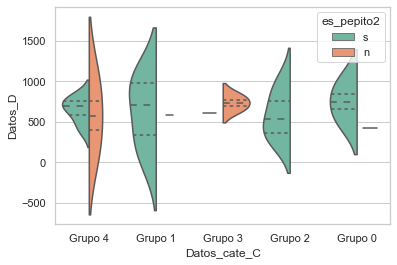

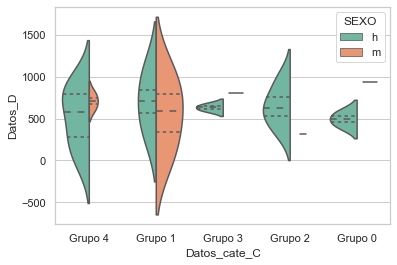

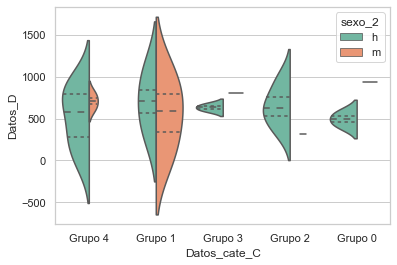

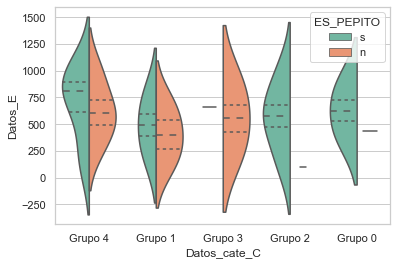

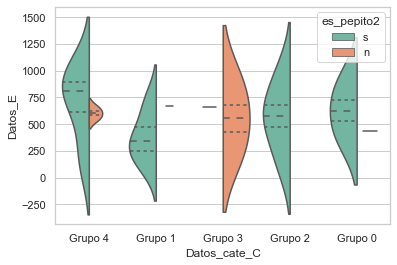

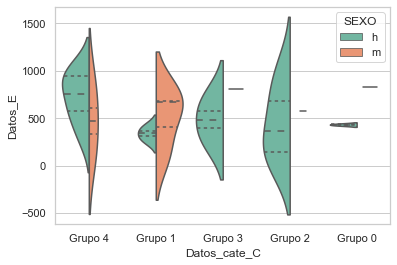

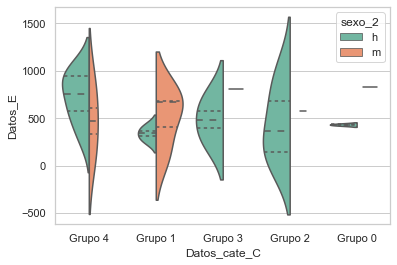

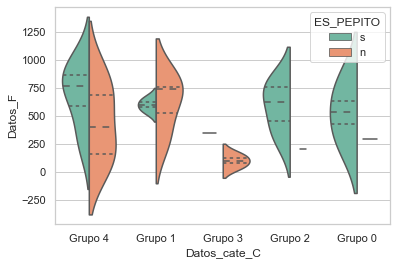

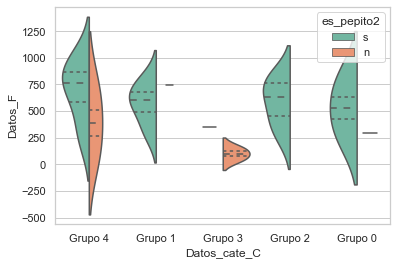

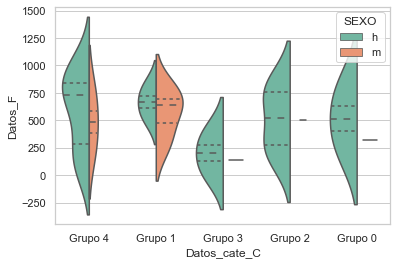

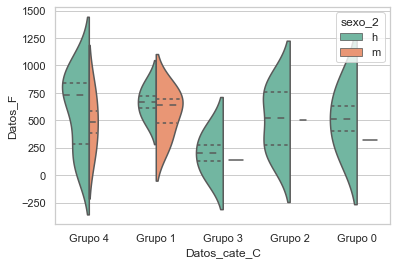

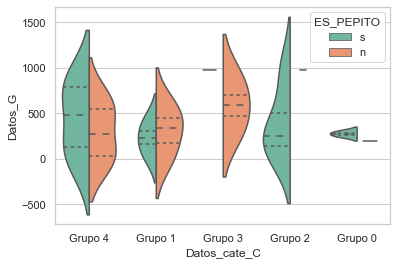

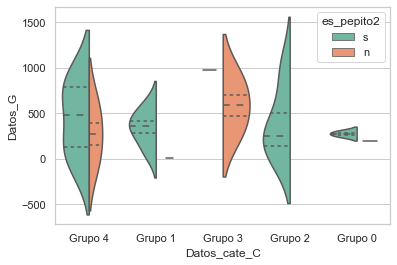

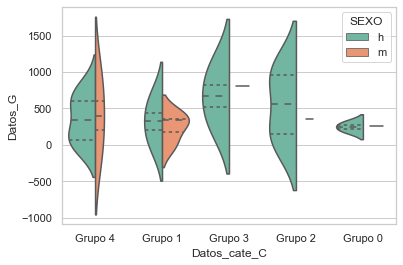

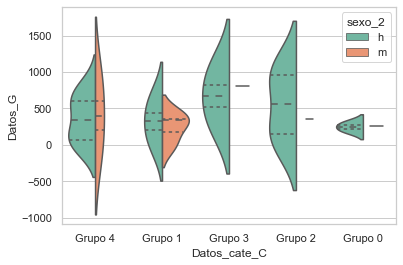

In [92]:
ejemplo.violines()

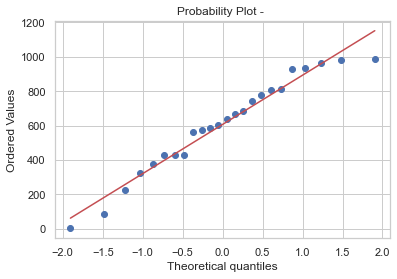

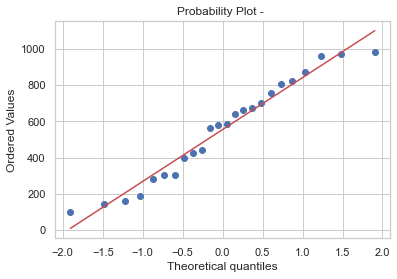

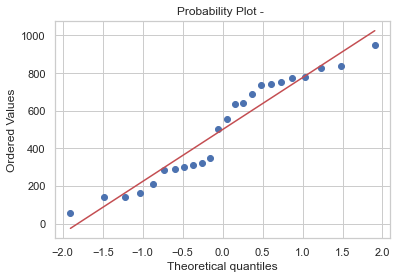

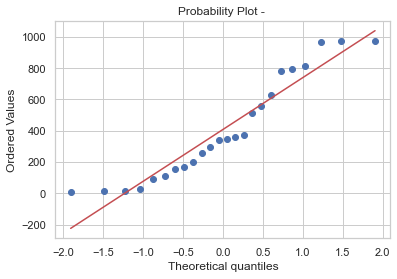

In [93]:
ejemplo.plot_normailidad()

# TEST ESTADISTICOS

## Variables normales y no normales

In [94]:
ejemplo.normalidad()

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_G  ++++++++++++++++++++++++++

Variable cuantitativa Datos_G y test Shapiro < 0.05
ShapiroResult(statistic=0.9017469882965088, pvalue=0.023443521931767464)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////
++++++++++++++++++++++++++++  ES_PEPITO y Datos_F  ++++++++++++++++++++++++++

Agrupado por ES_PEPITO y por Datos_F y test Shapiro < 0.05
ES_PEPITO
n    (0.8461716175079346, 0.03803651034832001)
s    (0.9246103167533875, 0.28926700353622437)
Name: Datos_F, dtype: object


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////
++++++++++++++++++++++++++++  ES_PEPITO y Datos_G  ++++++++++++++++++++++++

## Chi2

In [95]:
ejemplo.Chi()


-------------- Chi2 entre ES_PEPITO y es_pepito2 ----------------
p: 0.00022024132045215684 


-------------- Chi2 entre ES_PEPITO y SEXO ----------------
p: 0.5623426051791449 


-------------- Chi2 entre ES_PEPITO y sexo_2 ----------------
p: 0.5623426051791449 


-------------- Chi2 entre es_pepito2 y SEXO ----------------
p: 0.7762576671816586 


-------------- Chi2 entre es_pepito2 y sexo_2 ----------------
p: 0.7762576671816586 


-------------- Chi2 entre SEXO y sexo_2 ----------------
p: 9.63357008643095e-07 



## T_student

# Wilconxon

## Anova

In [96]:
ejemplo.anova()


----------- ANOVA Categoria Datos_B y variable continua Datos_D ----------

                sum_sq    df         F    PR(>F)
Datos_B   3.832348e+02   1.0  0.004731  0.945785
Residual  1.782174e+06  22.0       NaN       NaN

----------- ANOVA Categoria Datos_B y variable continua Datos_E ----------

                sum_sq    df         F    PR(>F)
Datos_B   5.516273e+03   1.0  0.068482  0.795994
Residual  1.772106e+06  22.0       NaN       NaN

----------- ANOVA Categoria Datos_B y variable continua Datos_F ----------

                sum_sq    df         F    PR(>F)
Datos_B   2.410521e+04   1.0  0.315238  0.580159
Residual  1.682267e+06  22.0       NaN       NaN

----------- ANOVA Categoria Datos_B y variable continua Datos_G ----------

                sum_sq    df         F    PR(>F)
Datos_B   6.661550e+04   1.0  0.601667  0.446201
Residual  2.435799e+06  22.0       NaN       NaN

----------- ANOVA Categoria Datos_cate_A y variable continua Datos_D ----------

                    su

In [97]:
# # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
# fvalue, pvalue = stats.f_oneway(df['A'], df['B'], df['C'], df['D'])
# print(fvalue, pvalue)
# # 17.492810457516338 2.639241146210922e-05

# # get ANOVA table as R like output
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# # Ordinary Least Squares (OLS) model
# model = ols('value ~ C(treatments)', data=df_melt).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# anova_table
# # output (ANOVA F and p value)
#                 sum_sq    df         F    PR(>F)
# C(treatments)  3010.95   3.0  17.49281  0.000026
# Residual        918.00  16.0       NaN       NaN

# # ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
# from bioinfokit.analys import stat
# res = stat()
# res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
# res.anova_summary
# # output (ANOVA F and p value)
#                  df   sum_sq   mean_sq         F    PR(>F)
# C(treatments)   3.0  3010.95  1003.650  17.49281  0.000026
# Residual       16.0   918.00    57.375       NaN       NaN

# # note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# # (typ parameter) will produce similar results.

In [98]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
#  
# for x in categorical_col:
#     model = ols('cnt' + '~' + x, data = BIKE).fit() #Oridnary least square method
#     result_anova = sm.stats.anova_lm(model) # ANOVA Test
#     print(result_anova)

In [99]:
# array1=["a","b","c"]
# array2=["d","e","f","g"]
# array3=["g"]

# def combinatoria(lista):
#     if len(lista)>2:
#         for ind, i in enumerate(lista):
#             for j in range(ind+1,len(lista)):
#                 print(f"i es : {i}")
#                 print(f"j es : {lista[j]}\n")
#     else:
#         print("******************** No suficientes argumentos ********************")
# combinatoria(array3)
